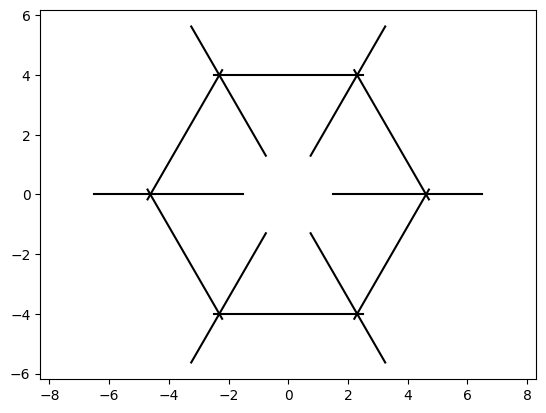

In [1]:
# turtle graphics for simple fences
import numpy as np

# K fences

def make_fences(K):
    pos = np.zeros((K, 2))
    angles = np.zeros(K)
    return pos, angles

def incrRot(angles, dir=1):
    K = len(angles)
    d_theta = 2*np.pi/K
    angles += d_theta * dir * np.arange(K)
    return angles

def incrPos(pos, angles, dir=1):
    K = len(angles)
    unit_vecs = np.array([np.cos(angles), np.sin(angles)]).T
    pos += unit_vecs * dir
    return pos

def compute_lines(centers, angles, line_length=5):
    K = len(angles)
    unit_vecs = np.array([np.cos(angles), np.sin(angles)]).T
    lines = np.zeros((K, 2, 2))
    lines[:, 0] = centers - unit_vecs * line_length/2
    lines[:, 1] = centers + unit_vecs * line_length/2
    return lines

def drawFences(pos, angles):
    import matplotlib.pyplot as plt
    lines = compute_lines(pos, angles)
    for line in lines:
        plt.plot(line[:, 0], line[:, 1], 'k-')
    plt.axis('equal')
    plt.show()

pos, angles = make_fences(12)
angles = incrRot(angles, dir=1)
pos = incrPos(pos, angles, dir=4)
angles = incrRot(angles, dir=3)
drawFences(pos, angles)


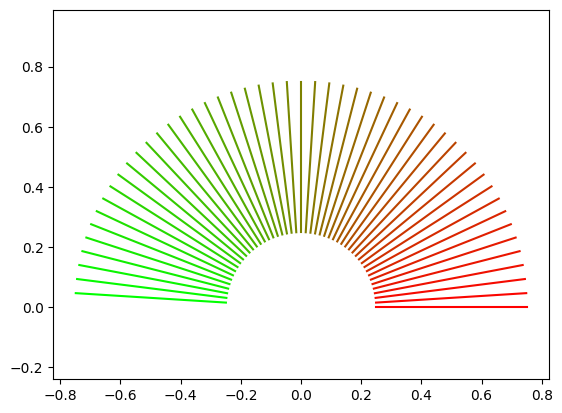

In [2]:


# rewritten in terms of basis vectors
# k < K describes the rotation index (not the same as angle/dtheta, but rather the number of times accumRot has been performed on the set of fences)
# n < N describes the fence index
# usually K = I
# x_k refers to the amount of forward movement performed under the k-th rotation
# p_i refers to the position of the i-th fence
from einops import einsum, rearrange

class BasisFences:

    def __init__(self, n_fences):
        self.N = n_fences
        self.K =  n_fences + n_fences  # not necessarily equal to N in the future
        self.k = 0  # start at no rotation
        self.X = np.zeros(self.K)
        # the basis vectors describe how to build the p_i from the x_k (It is a KxNx2 matrix)
        ns = np.arange(self.N)
        ks = np.arange(self.K)
        rots = ks[:, None] * ns[None, :]  # (i) gets rotated by n*dθ each time, so for the kth rotation, it is rotated by k*n*dθ
        rots = rots % self.K  # K*dθ = 2π, so we can reduce the rotation to the range [0, K)
        d_theta = 2*np.pi/self.K
        self.basis = np.empty((self.K, self.N, 2))
        self.basis[:, :, 0] = np.cos(d_theta * rots)
        self.basis[:, :, 1] = np.sin(d_theta * rots)
        # rendering
        self.line_length = 0.5

    def incrRot(self, dir=1):
        self.k = (self.k + dir) % self.K

    def incrPos(self, dir=1):
        self.X[self.k] += dir

    def compute_centers(self):
        self.centers = einsum(self.X, self.basis, 'k, k n z -> n z')  # z is the (x, y) coordinate pair; k is the rotation index; n is the fence index

    def compute_lines(self):
        self.compute_centers()
        self.lines = np.zeros((self.N, 2, 2))
        self.lines[:, 0] = self.centers - self.basis[self.k] * self.line_length/2
        self.lines[:, 1] = self.centers + self.basis[self.k] * self.line_length/2

    def solve_X(self, centers):
        # centers is a Nx2 array
        # we want to solve for X
        # X is a K array
        # we have the equation centers = einsum(X, basis, 'k, k n z -> n z')
        # first we flatten
        centers = rearrange(centers, 'n z -> (n z)')
        print('centers', centers.shape)
        basis = rearrange(self.basis, 'k n z -> (n z) k')
        print('basis', basis.shape)
        # print the degree of the basis
        print(np.linalg.matrix_rank(basis))
        # now basis @ X = centers, so we can solve for X
        solved_X = np.linalg.lstsq(basis, centers)[0]
        print('solved_X', solved_X.shape)
        return solved_X

    def drawFences(self):
        import matplotlib.pyplot as plt
        self.compute_lines()
        # gradient from red to green
        colors = np.linspace(0, 1, self.N)
        colors = np.array([[1-c, c, 0] for c in colors])
        for line, color in zip(self.lines, colors):
            plt.plot(line[:, 0], line[:, 1], color=color)
            pass
        # plt.scatter(centers[:, 0], centers[:, 1], color=colors, s=1)
        plt.axis('equal')
        plt.show()

N = 50
fences = BasisFences(N)
fences.incrRot(1)
fences.incrPos(0.5)
fences.drawFences()

In [3]:
desired_centers = np.empty((N, 2))
desired_centers[:, 0] = xs
desired_centers[:, 1] = ys
full_X = fences.solve_X(desired_centers)
trunc = 100
fences.X = full_X.copy()
fences.X[trunc:] = 0
fences.drawFences()

NameError: name 'xs' is not defined

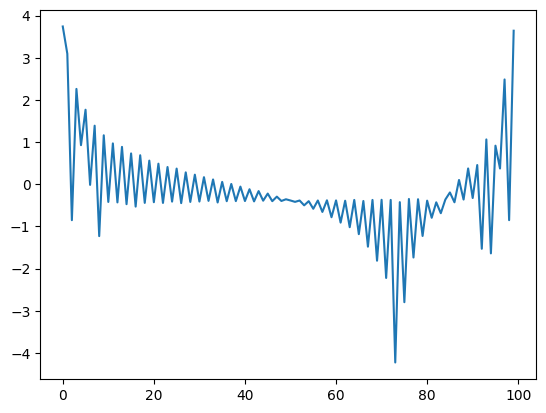

In [225]:
full_X
plt.plot(np.log(np.abs(full_X)))

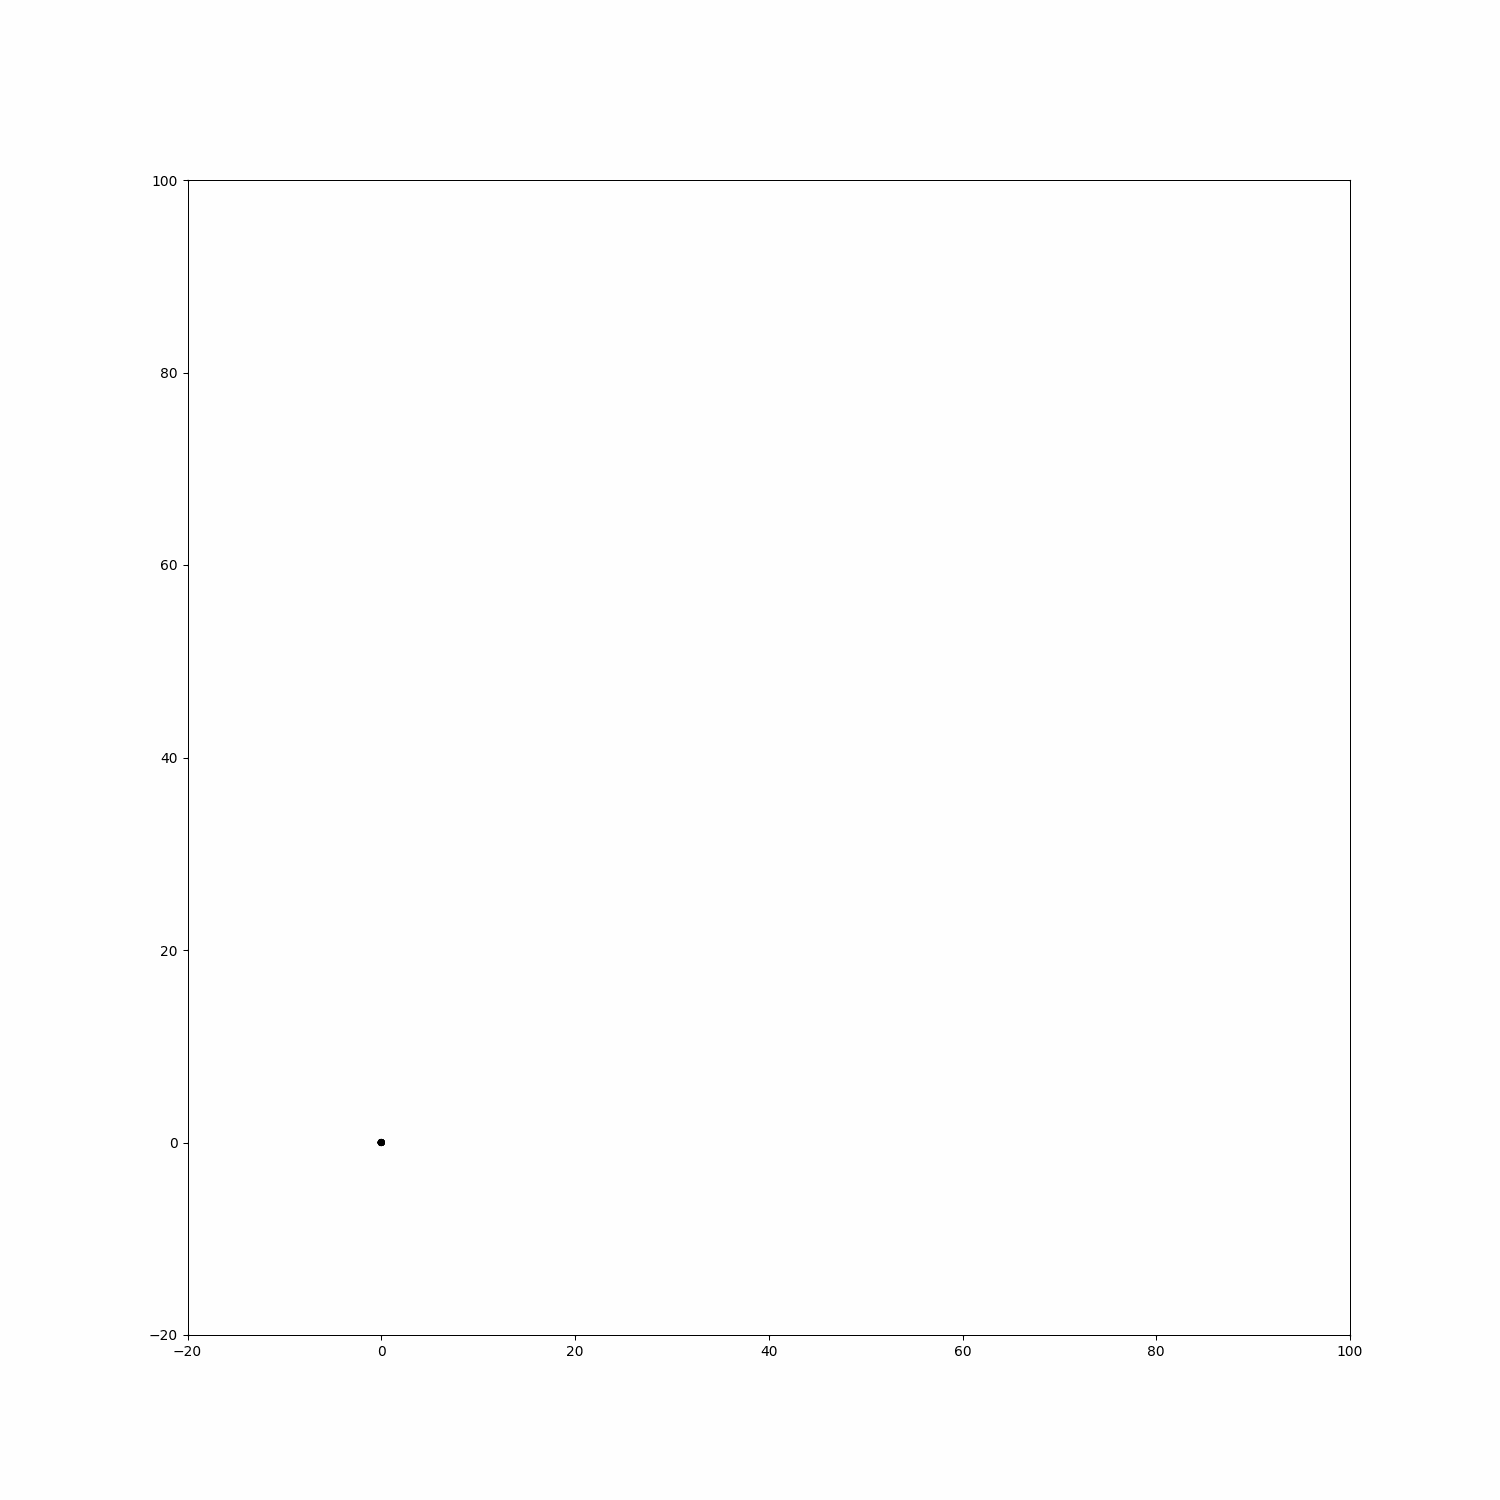

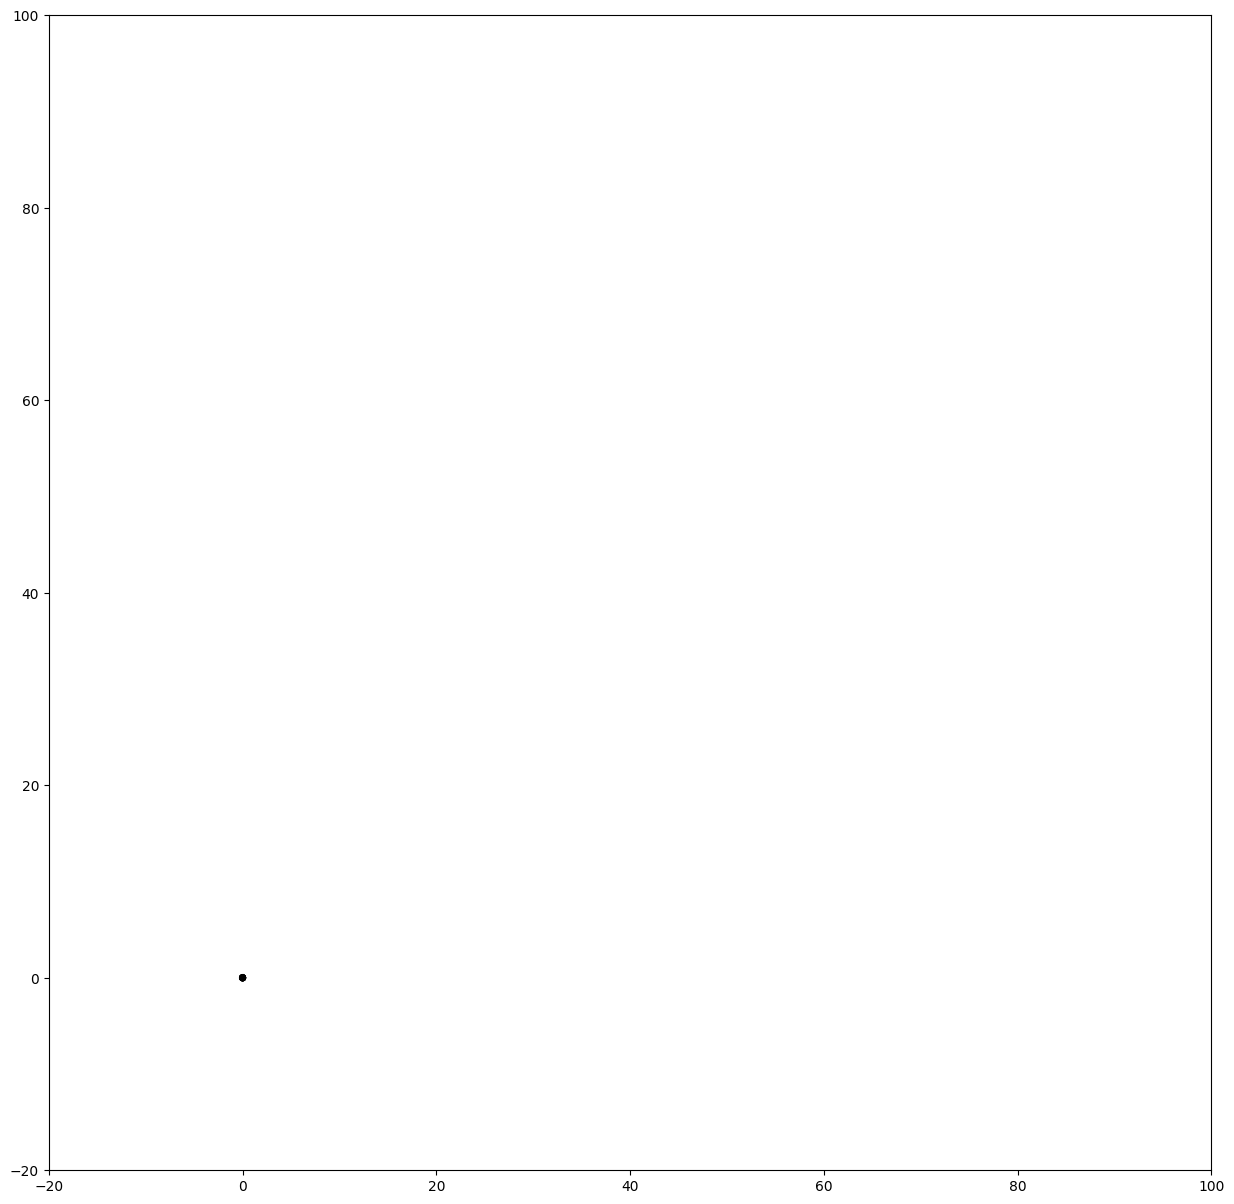

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Step 1: Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(-20, 100)
ax.set_ylim(-20, 100)
lines = [ax.plot([], [], 'k-')[0] for _ in range(N)]

# Step 2: Define the update function
def update(frame):
    trunc = frame
    fences.X = full_X.copy()
    fences.X[trunc:] = 0
    fences.compute_lines()
    for plt_line, line in zip(lines, fences.lines):
        plt_line.set_data(line[:, 0], line[:, 1])
    return lines

# Step 3: Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 200, 1), interval=100)

# Save the animation as a GIF and display it in the notebook
ani.save('sine_wave_animation.gif', writer='pillow')


from IPython.display import Image
Image(filename='sine_wave_animation.gif')


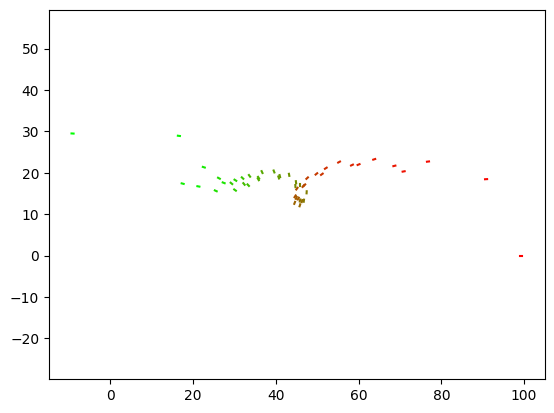

In [181]:
fences.drawFences()

Defaulting to user installation because normal site-packages is not writeable
Path(CubicBezier(start=(22.172162+76.731809j), control1=(21.701959+75.063632j), control2=(22.575791+68.914703j), end=(23.322313+65.75957j)),
     CubicBezier(start=(23.322313+65.75957j), control1=(24.616202+61.128198999999995j), control2=(26.074505000000002+57.684697j), end=(29.256845000000002+53.76406j)),
     CubicBezier(start=(29.256845000000002+53.76406j), control1=(32.335028+50.100237j), control2=(35.95003+46.956672j), end=(40.505868+45.574854j)),
     CubicBezier(start=(40.505868+45.574854j), control1=(45.063727+43.613419j), control2=(49.963145+43.475043j), end=(54.861201+43.633032j)),
     CubicBezier(start=(54.861201+43.633032j), control1=(60.249446+43.401678j), control2=(62.876928+50.386971j), end=(61.183635+54.750314j)),
     CubicBezier(start=(61.183635+54.750314j), control1=(58.631529+57.789495j), control2=(54.983225000000004+58.751017000000004j), end=(51.111817+59.500457000000004j)),
     CubicBe

(800, np.float64(-82.82184153743215), np.float64(-82.91653147567321))

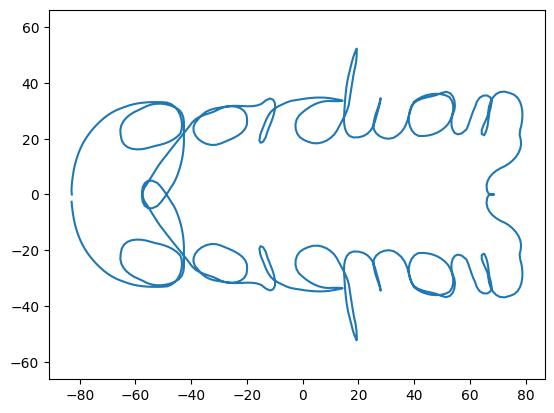

In [105]:
!pip install svgpathtools --break-system-packages
from svgpathtools import svg2paths, Path
import numpy as np

# Load the SVG file
# file_path = "test.svg"  # Replace with the path to your SVG file
file_path = "word_gordian.svg"
paths, attributes = svg2paths(file_path)

# Assuming the SVG contains one path, we'll use the first path
path: Path = paths[0]
print(path)
# path = "m 117.83513,69.080914 c 4.86854,-9.195953 18.51786,-5.453184 23.78818,-14.208261 5.28174,-5.020739 6.32879,-15.562173 -1.52716,-18.698563 -6.26935,-2.121981 -14.00296,1.431009 -17.44403,6.782028 -3.14664,6.242292 4.77879,14.217533 10.84177,9.97953 6.37337,-3.536526 10.23341,-12.954422 4.47145,-18.785571 -5.96273,-5.986392 -13.38707,0.75116 -17.66584,5.309756 -11.22284,12.28646 -16.68054,30.053251 -32.253918,38.082502 -8.831495,5.198153 -18.707102,8.245389 -27.708051,13.107924 11.050021,-0.790551 20.381184,-7.459696 30.159584,-11.966598 4.501074,-2.639149 8.826777,-5.695202 12.322515,-9.602686"

# Get the total length of the path
total_length = path.length()

# Define a function to get (x, y) as a function of path length
def get_xy_at_length(path, arc_length):
    # arc_length must be in the range [0, total_length]
    if arc_length < 0 or arc_length > total_length:
        raise ValueError("Arc length must be between 0 and the total length of the path")
    
    # path.point() returns a complex number, where real part is x and imaginary part is y
    point = path.point(arc_length / total_length)
    return point.real, point.imag

# Example: get coordinates at 25%, 50%, and 75% along the path
lengths = np.array([0.25, 0.5, 0.75]) * total_length

for arc_length in lengths:
    x, y = get_xy_at_length(path, arc_length)
    # print(f"At length {arc_length:.2f}, x = {x:.2f}, y = {y:.2f}")

ts = np.linspace(0, 1, 400 + 1)
points = [path.point(t) for t in ts]
xs = [p.real for p in points]
xs += [x for x in xs[-1:1:-1]]
avg_x = np.mean(xs)
xs = [x-avg_x for x in xs]
ys = [-p.imag for p in points]
ys = [y-ys[0] for y in ys]
ys += [-y for y in ys[-1:1:-1]]
import matplotlib.pyplot as plt
plt.plot(xs, ys)
plt.axis('equal')
len(xs), xs[0], xs[-1]


array([ 2.91877633e-13+2.65985717e-02j, -3.07273458e+02+1.23327729e+00j,
       -3.16261551e+01+2.75019865e-01j,  3.36002324e+01-3.69225738e-01j,
        2.16672912e+01-3.13728547e-01j,  6.69328011e+01-1.28773046e+00j,
       -5.55630440e+00+1.57614987e-01j,  4.92654238e+01-1.32790939e+00j,
        9.38077602e+00-2.68104383e-01j, -1.69455338e+01+6.25864959e-01j,
       -4.40706990e+01+1.75826583e+00j,  1.67785707e+01-6.98497522e-01j,
       -3.87117310e+01+1.85234724e+00j,  2.51586265e+01-1.25872613e+00j,
        3.14547102e+01-1.70428409e+00j, -1.38973411e+01+8.46354959e-01j,
       -2.01638900e+01+1.29540281e+00j,  1.17479775e+01-7.58637679e-01j,
       -5.86361494e+00+4.41989644e-01j, -2.36937899e+01+1.79798452e+00j,
        1.98321868e+00-1.29234171e-01j,  3.63363664e+01-2.97649451e+00j,
       -1.15338262e+01+1.02581125e+00j, -1.80535387e+01+1.66194467e+00j,
        2.55760204e+01-2.39074695e+00j,  1.58810046e+01-1.53723106e+00j,
       -1.77888873e+01+1.84953855e+00j, -2.66651936

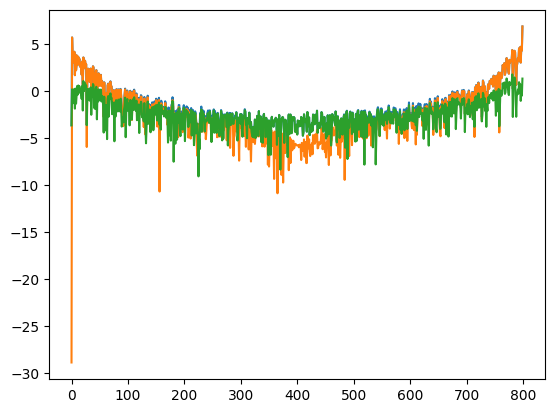

In [106]:
import numpy as np
import matplotlib
# fft package
scale = 40
cs = [complex(x, y)/scale for x, y in zip(xs, ys)]
freqs = np.fft.fft(cs)
plt.plot(np.log(np.abs(freqs)))
plt.plot(np.log(np.abs([f.real for f in freqs])))
plt.plot(np.log(np.abs([f.imag for f in freqs])))
freqs

(np.float64(-2.2770471788148385),
 np.float64(2.1711166433049094),
 np.float64(-1.3970684279237588),
 np.float64(1.3970684279237588))

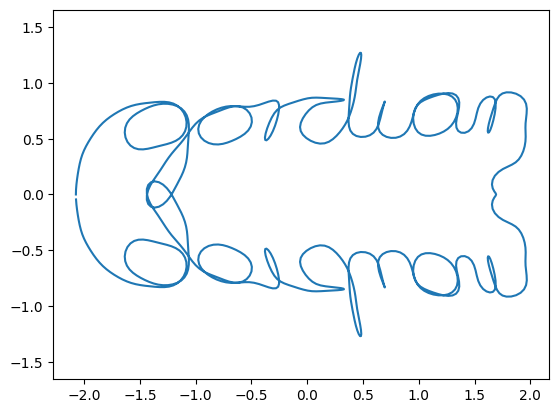

In [107]:
freqs2 = freqs.copy()
freqs2 = [complex(f.real, 0) for f in freqs2]  # remove imaginary part
freqs2 = np.array(freqs2)
freqs2[100:-100] = 0  # remove high frequency components
freqs2
cs2 = np.fft.ifft(freqs2)
plt.plot([c.real for c in cs2], [c.imag for c in cs2])
plt.axis('equal')

In [108]:
#  5    10    20    40
#     5    10    20    40
history = []

rot = 0
for k in range(5):
    n_consec = 5 * 2**k
    total_prev = sum(5 * 2**i for i in range(k))
    history.append([0, total_prev]); rot += total_prev  # go to the start of the next set of fences
    for _ in range(n_consec):
        history.append([0, 1]); rot += 1
        history.append([1, freqs[rot].real]); # print(rot)
    history.append([0, -rot]); rot -= rot  # back to 0
    history.append([0, -total_prev]); rot -= total_prev  # go to the start of the next set of fences
    for _ in range(n_consec):
        history.append([0, -1]); rot -= 1
        history.append([1, freqs[rot].real]); # print(rot)
    history.append([0, -rot]); rot += -rot  # back to 0

import json
json.dumps(history)

'[[0, 0], [0, 1], [1, -307.27345750331403], [0, 1], [1, -31.626155146830452], [0, 1], [1, 33.6002324262725], [0, 1], [1, 21.667291237376332], [0, 1], [1, 66.93280113112077], [0, -5], [0, 0], [0, -1], [1, -989.602761134426], [0, -1], [1, 76.40242199432052], [0, -1], [1, -116.30675817963625], [0, -1], [1, 21.31191593059344], [0, -1], [1, -109.99360240391294], [0, 5], [0, 5], [0, 1], [1, -5.556304396508623], [0, 1], [1, 49.26542384658319], [0, 1], [1, 9.380776016699201], [0, 1], [1, -16.945533801239154], [0, 1], [1, -44.070698994861836], [0, 1], [1, 16.778570730778533], [0, 1], [1, -38.711731024213265], [0, 1], [1, 25.15862648389578], [0, 1], [1, 31.454710168949013], [0, 1], [1, -13.89734111113678], [0, -15], [0, -5], [0, -1], [1, -43.56993663863324], [0, -1], [1, -96.5702776425749], [0, -1], [1, -25.52888123743443], [0, -1], [1, -34.676586737057], [0, -1], [1, -20.450963846802278], [0, -1], [1, -14.555164367925805], [0, -1], [1, -1.970439386498977], [0, -1], [1, -9.36547552883174], [0, -